In [1]:
import numpy as np
import scipy
import scipy.io as sio
import matplotlib.pyplot as plt
import nibabel as nib

import os
from os.path import join as opj
from os.path import join, exists, split
import time
import urllib.request
import warnings
from tqdm import tqdm
from pprint import pprint
import zipfile
import glob
warnings.filterwarnings('ignore')
from transformers import AutoFeatureExtractor, ClapModel
import torch
import torchaudio

from sklearn.linear_model import LogisticRegression, RidgeCV, Ridge
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder


import pandas as pd
from nilearn import maskers
from nilearn import plotting
import tqdm

from nilearn.glm.first_level import FirstLevelModel
from nilearn.image import concat_imgs, mean_img
import matplotlib.pyplot as plt
import nilearn
from nilearn.plotting import plot_design_matrix
from nilearn.plotting import plot_contrast_matrix
from importlib import reload # python 2.7 does not require this
from data_agg import *
import pickle
from nltools.data import Brain_Data, Adjacency
from nltools.stats import align

import seaborn as sns
import IPython.display as ipd
from sklearn.metrics import confusion_matrix

## LAVORARE QUA, NEL DICT working_data_subj_avg ho sempre gli stessi dati forse devo rinannare il codice e controllare

In [2]:
# %pip install nltools

In [2]:
data_dict = {}

In [3]:
transform_masking=True
subject_ids = ["sub-001", "sub-002", "sub-003", "sub-004", "sub-005"]

In [ ]:
load_cache=False

if not load_cache:
    # Initialize an empty dictionary to store the data
    mask=False
    avg=False

    # Loop over each subject ID
    for subject_id in subject_ids:

        print("[INFO] Analyzing sub", subject_id)
        # Load data for the current subject
        train_fmri_avg,train_audio_feat,train_genre,train_audio,test_fmri_avg,test_audio_feat,test_genre,test_audio, masker,train_stim_name, test_stim_name = load_data(subject_id,avg,mask)

        # Store the data in the dictionary
        data_dict[subject_id] = {
            "train_fmri": train_fmri_avg,
            "train_audio_feat": train_audio_feat,
            "train_genre": train_genre,
            "train_audio": train_audio,
            "test_fmri": test_fmri_avg,
            "test_audio_feat": test_audio_feat,
            "test_genre": test_genre,
            "test_audio" : test_audio,
            "masker": masker,
            "train_stim_name": train_stim_name, 
            "test_stim_name": test_stim_name
        }
        


In [ ]:
# with open('/data01/data/fMRI_music_genre/data_dict_tp' + '.pkl', 'wb') as file_to_write:
#     pickle.dump(data_dict, file_to_write, protocol=pickle.HIGHEST_PROTOCOL)

# train_fmri_dict = {              
#     subj: {'train_fmri': data_dict[subj]['train_fmri']}
#     for subj in data_dict
# }

with open('/srv/nfs-data/sisko/matteoc/music/data_dict' + '.pkl', 'rb') as file_to_read:
    data_dict = pickle.load(file_to_read)

In [6]:
print(data_dict['sub-001']['train_audio_feat'].shape)
print(data_dict['sub-001']['train_fmri'].shape)
print(data_dict['sub-002']['train_audio_feat'].shape)
print(data_dict['sub-002']['train_fmri'].shape)
print(len(data_dict['sub-001']['train_genre']))
print(len(data_dict['sub-001']['train_stim_name']))
print(data_dict['sub-001']['test_audio_feat'].shape)
print(data_dict['sub-001']['test_fmri'].shape)
print(len(data_dict['sub-001']['test_genre']))
print(len(data_dict['sub-001']['test_stim_name']))

torch.Size([492, 512])
torch.Size([492, 10, 237653])
torch.Size([492, 512])
torch.Size([492, 10, 230762])
492
492
torch.Size([246, 512])
torch.Size([246, 10, 237653])
246
246


In [5]:
def load_transformed_data(data_folder):
    # Initialize an empty dictionary to store the data
    loaded_data_dict = {}

    # Loop through all files in the data folder
    for filename in os.listdir(data_folder):
        # Construct the full path of the file
        file_path = os.path.join(data_folder, filename)
        
        # Extract the subject ID and key from the filename
        # Assuming filenames are in the format 'sub_key.ext'
        sub, key = filename.split('_', 1)
        key = key.rsplit('.', 1)[0]  # Removes extension part to get the key
        
        #repeat
        key = key.rsplit('.', 1)[0]  # Removes extension part to get the key

        # Initialize sub dictionary if it doesn't exist
        if sub not in loaded_data_dict:
            loaded_data_dict[sub] = {}

        # Determine the file type and load accordingly
        if filename.endswith('.npy'):
            loaded_data_dict[sub][key] = np.load(file_path)
        elif filename.endswith('.pkl'):
            with open(file_path, 'rb') as file:
                loaded_data_dict[sub][key] = pickle.load(file)

        print(f"Loaded {key} from {file_path}")

    return loaded_data_dict


In [ ]:
#RESET masking to the same number of voxels

if transform_masking:
    working_data_dict = data_dict.copy()
    base_masker=working_data_dict["sub-001"]["masker"]
    for sub in subject_ids:

        x_tr=working_data_dict[sub]["train_fmri"]
        x_ts=working_data_dict[sub]["test_fmri"]
        masker = working_data_dict[sub]["masker"]

        x_tr_list=[]
        for x in tqdm.tqdm(x_tr):
            #undo masking

            tmp = masker.inverse_transform(x)
            x_tr_list.append(base_masker.transform(tmp))

        x_tr = torch.tensor(np.stack(x_tr_list))


        x_ts_list=[]
        for x in tqdm.tqdm(x_ts):
            tmp = masker.inverse_transform(x)
            x_ts_list.append(base_masker.transform(tmp))

        #undo masking
        x_ts = torch.tensor(np.stack(x_ts_list))
        working_data_dict[sub]["train_fmri"] = x_tr
        working_data_dict[sub]["test_fmri"] = x_ts



In [7]:
with open('/srv/nfs-data/sisko/matteoc/music/working_data_dict' + '.pkl', 'rb') as file_to_read:
    working_data_dict = pickle.load(file_to_read)

In [11]:
mask_path = "mask_to_save/mask_him_005.nii.gz"
# mask_path = "mask_01.nii.gz"
if transform_masking:
    base_masker=working_data_dict["sub-001"]["masker"]
    selected_indices=base_masker.transform(nib.load(mask_path))
    for sub in subject_ids:
        working_data_dict[sub]["train_fmri_avg"]=working_data_dict[sub]["train_fmri"].squeeze()[:,selected_indices.squeeze().astype(np.uint8)]
        working_data_dict[sub]["test_fmri_avg"]=working_data_dict[sub]["test_fmri"].squeeze()[:,selected_indices.squeeze().astype(np.uint8)]
        # working_data_dict[sub]["train_fmri_avg"]=working_data_dict[sub]["train_fmri"].squeeze()[:,:,selected_indices.squeeze().astype(np.uint8)]
        # working_data_dict[sub]["test_fmri_avg"]=working_data_dict[sub]["test_fmri"].squeeze()[:,:,selected_indices.squeeze().astype(np.uint8)]


In [12]:
working_data_dict[sub].keys()

dict_keys(['train_fmri', 'train_audio_feat', 'train_genre', 'train_audio', 'test_fmri', 'test_audio_feat', 'test_genre', 'test_audio', 'masker', 'train_stim_name', 'test_stim_name', 'train_fmri_avg', 'test_fmri_avg'])

In [13]:
if transform_masking:

    # Ensure the data directory exists
    data_folder = 'data'
    os.makedirs(data_folder, exist_ok=True)

    # Assuming working_data_dict is your main dictionary and 'sub' is defined
    for sub in subject_ids:
        for key, value in working_data_dict[sub].items():
            # Convert the value to a numpy array if it's not already one 
            print(key)

            # Define the path for the output file
            file_path = os.path.join(data_folder, f'{sub}_{key}.npy')

            # Check if the value is a numpy array
            if isinstance(value, np.ndarray):
                # Save the numpy array to a file with .npy extension
                np.save(file_path + '.npy', value)
                print(f"Saved {key} as an array to {file_path}.npy")
            else:
                # Save other types of data using pickle with .pkl extension
                with open(file_path + '.pkl', 'wb') as file:
                    pickle.dump(value, file, protocol=pickle.HIGHEST_PROTOCOL)
                print(f"Saved {key} using pickle to {file_path}.pkl")

            print(f"Saved {key} to {file_path}")

        
else:
    # Use the function
    data_folder = 'data'  # Specify the data folder path
    working_data_dict = load_transformed_data(data_folder)

train_fmri
Saved train_fmri using pickle to data/sub-001_train_fmri.npy.pkl
Saved train_fmri to data/sub-001_train_fmri.npy
train_audio_feat
Saved train_audio_feat using pickle to data/sub-001_train_audio_feat.npy.pkl
Saved train_audio_feat to data/sub-001_train_audio_feat.npy
train_genre
Saved train_genre using pickle to data/sub-001_train_genre.npy.pkl
Saved train_genre to data/sub-001_train_genre.npy
train_audio
Saved train_audio using pickle to data/sub-001_train_audio.npy.pkl
Saved train_audio to data/sub-001_train_audio.npy
test_fmri
Saved test_fmri using pickle to data/sub-001_test_fmri.npy.pkl
Saved test_fmri to data/sub-001_test_fmri.npy
test_audio_feat
Saved test_audio_feat using pickle to data/sub-001_test_audio_feat.npy.pkl
Saved test_audio_feat to data/sub-001_test_audio_feat.npy
test_genre
Saved test_genre using pickle to data/sub-001_test_genre.npy.pkl
Saved test_genre to data/sub-001_test_genre.npy
test_audio
Saved test_audio using pickle to data/sub-001_test_audio.npy.

In [14]:
torch.equal(working_data_dict["sub-001"]["train_fmri"],working_data_dict["sub-002"]["train_fmri"])

False

In [15]:
## check if genre sequences are the same

for sub in subject_ids:
    print(working_data_dict[sub]["train_fmri"].shape)
    print()
    print(working_data_dict[sub]["test_fmri"].shape)


torch.Size([492, 1, 237653])

torch.Size([246, 1, 237653])
torch.Size([492, 1, 237653])

torch.Size([246, 1, 237653])
torch.Size([492, 1, 237653])

torch.Size([246, 1, 237653])
torch.Size([492, 1, 237653])

torch.Size([246, 1, 237653])
torch.Size([492, 1, 237653])

torch.Size([246, 1, 237653])


In [53]:
## TO DO 

# find duplicates in training set, average their activity.

# find duplicates in test set, average their activity

# match indices in training and test dataset across subject, sort data

# do functional alignment

In [16]:
print(working_data_dict['sub-001']['train_audio_feat'].shape)
print(working_data_dict['sub-001']['train_fmri'].shape)
print(working_data_dict['sub-001']['train_fmri_avg'].shape)
print(len(working_data_dict['sub-001']['train_genre']))
print(len(working_data_dict['sub-001']['train_stim_name']))
print(working_data_dict['sub-001']['test_audio_feat'].shape)
print(working_data_dict['sub-001']['test_fmri'].shape)
print(working_data_dict['sub-001']['test_fmri_avg'].shape)
print(len(working_data_dict['sub-001']['test_genre']))
print(len(working_data_dict['sub-001']['test_stim_name']))

torch.Size([492, 512])
torch.Size([492, 1, 237653])
torch.Size([492, 3043])
492
492
torch.Size([246, 512])
torch.Size([246, 1, 237653])
torch.Size([246, 3043])
246
246


In [17]:
import pandas as pd

def process_data(data_dict, key_suffix, features_key, genre_key, stim_name_key, fmri_key):
    # Create DataFrame for fMRI and stimulus names
    df = pd.DataFrame(data_dict[fmri_key], dtype=float)
    # df = pd.DataFrame(data_dict[fmri_key][:,8], dtype=float)       -> ID Accuracy in time
    df['Stimulus'] = data_dict[stim_name_key]
    
    # Group by 'Stimulus' and calculate the mean for fMRI data
    fmri_avg = df.groupby('Stimulus').mean().reset_index()
    
    # Create DataFrame for audio features and stimulus names
    df_features = pd.DataFrame(data_dict[features_key], dtype=float)
    df_features['Stimulus'] = data_dict[stim_name_key]
    
    # Group by 'Stimulus' and calculate the mean for audio features
    features_avg = df_features.groupby('Stimulus').mean().reset_index()
    
    # Handle genres (assuming genre data is aligned with stimuli names)
    df_genre = pd.DataFrame(data_dict[genre_key], columns=['Genre'])
    df_genre['Stimulus'] = data_dict[stim_name_key]
    
    # Since genre should be consistent for the same stimulus, we can take the first occurrence
    genre_avg = df_genre.groupby('Stimulus').first().reset_index()
    
    return {
        key_suffix + '_audio_feat': features_avg.drop(columns='Stimulus').values,
        key_suffix + '_genre': genre_avg['Genre'].values,
        key_suffix + '_stim_name_avg': fmri_avg['Stimulus'].values,
        key_suffix + '_fmri_avg': fmri_avg.drop(columns='Stimulus').values
    }

working_data_dict_avg={}
for sub in subject_ids:
    # Assuming working_data_dict is already defined and filled with your data
    working_data_dict_avg[sub]={}

    # Process training data
    working_data_dict_avg[sub].update(
        process_data(
            working_data_dict[sub],
            'train',
            'train_audio_feat',
            'train_genre',
            'train_stim_name',
            'train_fmri_avg'
        )
    )

    # Process testing data
    working_data_dict_avg[sub].update(
        process_data(
            working_data_dict[sub],
            'test',
            'test_audio_feat',
            'test_genre',
            'test_stim_name',
            'test_fmri_avg'
        )
    )


In [18]:
# Function to print dimensions and examples
def print_key_details(data_dict):
    for key, value in data_dict.items():
        # Print the dimensions of each item
        if isinstance(value, np.ndarray):
            print(f"Key: {key}, Dimensions: {value.shape}")
        else:
            print(f"Key: {key}, Type: {type(value)}")
        
        # Print some example data for genre and stimuli names
        if 'genre' in key or 'stim_name' in key:
            print(f"Example data for {key}: {value[:5]}")  # Print first 5 examples

for sub in subject_ids:
    # Assuming working_data_dict_avg is already populated and structured correctly
    print_key_details(working_data_dict_avg[sub])

Key: train_audio_feat, Dimensions: (480, 512)
Key: train_genre, Dimensions: (480,)
Example data for train_genre: ['blues' 'blues' 'blues' 'blues' 'blues']
Key: train_stim_name_avg, Dimensions: (480,)
Example data for train_stim_name_avg: ['/data01/data/fMRI_music_genre/data_wav/genres_original/blues/blues.00000.wav'
 '/data01/data/fMRI_music_genre/data_wav/genres_original/blues/blues.00002.wav'
 '/data01/data/fMRI_music_genre/data_wav/genres_original/blues/blues.00005.wav'
 '/data01/data/fMRI_music_genre/data_wav/genres_original/blues/blues.00006.wav'
 '/data01/data/fMRI_music_genre/data_wav/genres_original/blues/blues.00010.wav']
Key: train_fmri_avg, Dimensions: (480, 3043)
Key: test_audio_feat, Dimensions: (60, 512)
Key: test_genre, Dimensions: (60,)
Example data for test_genre: ['blues' 'blues' 'blues' 'blues' 'blues']
Key: test_stim_name_avg, Dimensions: (60,)
Example data for test_stim_name_avg: ['/data01/data/fMRI_music_genre/data_wav/genres_original/blues/blues.00016.wav'
 '/dat

## Reorder data

In [13]:
import pickle
import os


save_out_data=True

if save_out_data:
    # Ensure the 'data' directory exists
    if not os.path.exists('data'):
        os.makedirs('data')

    # Path to save the pickle file
    pickle_file_path = 'data/working_data_dict_avg.pkl'

    # Serialize and save the dictionary using pickle
    with open(pickle_file_path, 'wb') as file:
        pickle.dump(working_data_dict_avg, file)

    print(f'Data successfully saved to {pickle_file_path}')
    
else:
    # Path to the pickle file
    pickle_file_path = 'data/working_data_dict_avg.pkl'

    # Deserialize the dictionary from the pickle file
    with open(pickle_file_path, 'rb') as file:
        working_data_dict_avg = pickle.load(file)

    print('Data successfully loaded.')
    print(working_data_dict_avg)  # Optionally print or inspect some part of the loaded data

Data successfully saved to data/working_data_dict_avg.pkl


## Functional Alignment

In [21]:
print(working_data_dict_avg['sub-001']['train_audio_feat'].shape)
print(working_data_dict_avg['sub-001']['train_fmri_avg'].shape)
print(working_data_dict_avg['sub-001']['train_genre'].shape)
print(working_data_dict_avg['sub-001']['train_stim_name_avg'].shape)
print(working_data_dict_avg['sub-001']['test_audio_feat'].shape)
print(working_data_dict_avg['sub-001']['test_fmri_avg'].shape)
print(working_data_dict_avg['sub-001']['test_genre'].shape)
print(working_data_dict_avg['sub-001']['test_stim_name_avg'].shape)

(480, 512)
(480, 3043)
(480,)
(480,)
(60, 512)
(60, 3043)
(60,)
(60,)


In [20]:
# STRONGER FUNCTIONAL ALIGNMENT

target_sub="sub-001"

# X_train_aligned = [working_data_dict_avg[source_sub]["train_fmri_avg"]]
# X_test_aligned  = [working_data_dict_avg[source_sub]["test_fmri_avg"]]
X_train_aligned = []
X_test_aligned  = []


for source_sub in subject_ids:

    print(source_sub)
    source_train=working_data_dict_avg[source_sub]["train_fmri_avg"]
    target_train=working_data_dict_avg[target_sub]["train_fmri_avg"]

    source_test=working_data_dict_avg[source_sub]["test_fmri_avg"]
    target_test=working_data_dict_avg[target_sub]["test_fmri_avg"]

    
    aligner=RidgeCV(alphas=[1e2,1e3,1e4,5e4], fit_intercept=True)
    aligner.fit(source_train,target_train)

    aligned_source_test=aligner.predict(source_test)
    aligned_source_train=aligner.predict(source_train)

    aligned_source_train_adj = (aligned_source_train - aligned_source_train.mean(0)) / (1e-8 + aligned_source_train.std(0))
    aligned_source_train_adj = target_train.std(0) * aligned_source_train_adj + target_train.mean(0)

    # Align and adjust source_test dataset
    aligned_source_test_adj = (aligned_source_test - aligned_source_test.mean(0)) / (1e-8 + aligned_source_test.std(0))
    aligned_source_test_adj = target_train.std(0) * aligned_source_test_adj + target_train.mean(0)
    
    X_train_aligned.append(aligned_source_train_adj)
    X_test_aligned.append(aligned_source_test_adj)
    
#concatenate all

X_train_aligned = np.concatenate(X_train_aligned,0)
X_test_aligned = np.concatenate(X_test_aligned,0)

#concatenate all the other keys

train_audio_feat_aligned = np.concatenate([working_data_dict_avg[sub]["train_audio_feat"] for sub in subject_ids],0)
test_audio_feat_aligned = np.concatenate([working_data_dict_avg[sub]["test_audio_feat"] for sub in subject_ids],0)

train_genre_aligned = np.concatenate([working_data_dict_avg[sub]["train_genre"] for sub in subject_ids],0)
test_genre_aligned = np.concatenate([working_data_dict_avg[sub]["test_genre"] for sub in subject_ids],0)

train_stim_name_avg_aligned = np.concatenate([working_data_dict_avg[sub]["train_stim_name_avg"] for sub in subject_ids],0)
test_stim_name_avg_aligned = np.concatenate([working_data_dict_avg[sub]["test_stim_name_avg"] for sub in subject_ids],0)


sub-001
sub-002
sub-003
sub-004
sub-005


In [ ]:
# WEAKER FUNCTIONAL ALIGNMENT

target_sub="sub-001"

# X_train_aligned = [working_data_dict_avg[source_sub]["train_fmri_avg"]]
# X_test_aligned  = [working_data_dict_avg[source_sub]["test_fmri_avg"]]
X_train_aligned = []
X_test_aligned  = []


for source_sub in subject_ids:

    print(source_sub)
    source_train=working_data_dict_avg[source_sub]["train_fmri_avg"]
    target_train=working_data_dict_avg[target_sub]["train_fmri_avg"]

    source_test=working_data_dict_avg[source_sub]["test_fmri_avg"]
    target_test=working_data_dict_avg[target_sub]["test_fmri_avg"]


    source = Brain_Data()
    target = Brain_Data()

    # Load real data into Brain_Data instances
    source.data = source_train # Replace with actual source data
    target.data = target_train

    # Align source to target
    source_aligned = source.align(target)

    # Extract transformation matrix
    transformation_matrix = source_aligned["transformation_matrix"].data.T

    # Align and adjust source_train dataset
    aligned_source_train = source_train @ transformation_matrix
    aligned_source_train_adj = (aligned_source_train - aligned_source_train.mean(0)) / (1e-8 + aligned_source_train.std(0))
    aligned_source_train_adj = target.data.std(0) * aligned_source_train_adj + target.data.mean(0)

    # Align and adjust source_test dataset
    aligned_source_test = source_test @ transformation_matrix
    aligned_source_test_adj = (aligned_source_test - aligned_source_test.mean(0)) / (1e-8 + aligned_source_test.std(0))
    aligned_source_test_adj = target.data.std(0) * aligned_source_test_adj + target.data.mean(0)
    
    X_train_aligned.append(aligned_source_train_adj)
    X_test_aligned.append(aligned_source_test_adj)
    
#concatenate all

X_train_aligned = np.concatenate(X_train_aligned,0)
X_test_aligned = np.concatenate(X_test_aligned,0)

#concatenate all the other keys

train_audio_feat_aligned = np.concatenate([working_data_dict_avg[sub]["train_audio_feat"] for sub in subject_ids],0)
test_audio_feat_aligned = np.concatenate([working_data_dict_avg[sub]["test_audio_feat"] for sub in subject_ids],0)

train_genre_aligned = np.concatenate([working_data_dict_avg[sub]["train_genre"] for sub in subject_ids],0)
test_genre_aligned = np.concatenate([working_data_dict_avg[sub]["test_genre"] for sub in subject_ids],0)

train_stim_name_avg_aligned = np.concatenate([working_data_dict_avg[sub]["train_stim_name_avg"] for sub in subject_ids],0)
test_stim_name_avg_aligned = np.concatenate([working_data_dict_avg[sub]["test_stim_name_avg"] for sub in subject_ids],0)



sub-001
sub-002
sub-003
sub-004
sub-005


## align on common space

In [16]:
le=LabelEncoder()

train_genre_enc=le.fit_transform(train_genre_aligned)
test_genre_enc=le.transform(test_genre_aligned)

X_train=X_train_aligned.copy()
X_test=X_test_aligned.copy()

clf_genre = LogisticRegression(C=10,random_state=0).fit(X_train, train_genre_enc)

y_pred_genre = clf_genre.predict(X_test)

print(classification_report(test_genre_enc,y_pred_genre))

              precision    recall  f1-score   support

           0       0.47      0.47      0.47        30
           1       0.73      1.00      0.85        30
           2       0.42      0.53      0.47        30
           3       0.36      0.33      0.34        30
           4       0.64      0.83      0.72        30
           5       0.74      0.57      0.64        30
           6       0.56      0.63      0.59        30
           7       0.61      0.67      0.63        30
           8       0.61      0.47      0.53        30
           9       0.27      0.10      0.15        30

    accuracy                           0.56       300
   macro avg       0.54      0.56      0.54       300
weighted avg       0.54      0.56      0.54       300



## Decoding: Feature Estimation

In [17]:
## train a Ridge regression between X_train and audio_features
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, normalize

# brain_to_latent=RidgeCV(alphas=[1e-2,0.1,1,2,5,8,10,15,20,50,1e2,1e3])
brain_to_latent=Ridge(alpha=20)

brain_to_latent.fit(X_train, train_audio_feat_aligned)

Ridge(alpha=20)

In [18]:
audio_feat_pred=brain_to_latent.predict(X_test)

In [19]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(test_audio_feat_aligned[:60])


In [20]:
audio_feat_pred.shape

(300, 512)

In [21]:
distances, top_indices = nbrs.kneighbors(audio_feat_pred)

In [22]:
top_indices.shape

(300, 5)

In [23]:
np.where(test_genre_aligned == 'blues')[0], np.where(test_genre_enc == 0)[0]

(array([  0,   1,   2,   3,   4,   5,  60,  61,  62,  63,  64,  65, 120,
        121, 122, 123, 124, 125, 180, 181, 182, 183, 184, 185, 240, 241,
        242, 243, 244, 245]),
 array([  0,   1,   2,   3,   4,   5,  60,  61,  62,  63,  64,  65, 120,
        121, 122, 123, 124, 125, 180, 181, 182, 183, 184, 185, 240, 241,
        242, 243, 244, 245]))

## Identification Accuracy

In [ ]:
from scipy.stats import pearsonr

def identification_accuracy(P, T):
    n = P.shape[0]
    C = np.zeros((n, n))
    
    # Compute the correlation matrix
    for i in tqdm.trange(n):
        for j in range(n):
            C[i, j], _ = pearsonr(P[i], T[j])
    
    # Compute identification accuracy per prediction
    id_acc = np.zeros(n)
    for i in tqdm.trange(n):
        id_acc[i] = (C[i, i] >= C[i]).sum() 
        id_acc[i] = id_acc[i] / (n - 1)

    # Average identification accuracy
    overall_id_acc = np.mean(id_acc)
    
    return overall_id_acc


In [25]:
print(test_genre_aligned[59])
print(test_genre_aligned[60])

rock
blues


In [26]:
# identification acc
id_accs=[]
for i in range(5):
    
    id_acc=identification_accuracy(audio_feat_pred[60*i:60*(i+1)],test_audio_feat_aligned[60*i:60*(i+1)])
    id_accs.append(id_acc)
    
np.mean(id_accs), np.std(id_accs)




100%|██████████| 60/60 [00:00<00:00, 193285.90it/s]


(0.9281355932203388, 0.02101861970154393)

In [29]:
print(id_accs)

[0.9350282485875706, 0.9358757062146892, 0.9189265536723162, 0.8937853107344631, 0.9570621468926553]


## Top-1/Top-3 analysis

In [30]:
retrieval={}
for subject in subject_ids:
    retrieval[subject]={"true":[working_data_dict_avg[subject]["test_stim_name_avg"][idx] for idx in range(60)],
                        "retrieved":[working_data_dict_avg[subject]["test_stim_name_avg"][top_indices[idx]] for idx in range(60)]
                       }
    

In [29]:
# Save the dictionary using pickle
with open('retrieval_data.pkl', 'wb') as file:
    pickle.dump(retrieval, file)

In [31]:
top_indices_3 = top_indices[:,:3]
top_indices_3subj = top_indices_3.reshape([5, 60, 3])
print(top_indices_3.shape)
print(top_indices_3subj.shape)

(300, 3)
(5, 60, 3)


In [32]:
top_indices_3[0], top_indices_3[60]

(array([30, 33, 32]), array([ 1, 16, 30]))

In [37]:
# per canzone

sub_idx = 4
count_top_1 = 0
count_top_3 = 0
for idx in range(60):
    file_name_with_extension = str(test_stim_name_avg_aligned[:60][idx]).split('/')[-1]
    file_name = file_name_with_extension.replace('.wav', '')
    file_names_retrieved = [file_path.split('/')[-1].replace('.wav', '') for file_path in test_stim_name_avg_aligned[:60][top_indices_3subj[sub_idx][idx]]]
    if file_name == file_names_retrieved[0]:
        count_top_1 = count_top_1 + 1
    if file_name in file_names_retrieved:
        count_top_3 = count_top_3 + 1
    # print(test_genre_aligned[:60][idx])
    # print(test_stim_name_avg_aligned[:60][idx])
    # print(test_genre_aligned[:60][top_indices_3[idx]])
    # print(test_stim_name_avg_aligned[:60][top_indices_3[idx]])
    # ipd.Audio(working_data_dict_avg[f"sub-00{sub_idx}"]["test_stim_name_avg"][idx],rate=22500)

print('count_top_1: ',count_top_1)
print('count_top_3: ',count_top_3)

# top_1_song_mean = (np.mean([14, 12, 11, 12, 14])/60)*100
# top_1_song_std = (np.std([14, 12, 11, 12, 14])/60)*100

# top_3_song_mean = (np.mean([24, 23, 25, 29, 31])/60)*100
# top_3_song_std = (np.std([24, 23, 25, 29, 31])/60)*100

count_top_1:  20
count_top_3:  35


In [38]:
top_1_song_mean = (np.mean([16, 12, 11, 14, 20])/60)*100
top_1_song_std = (np.std([16, 12, 11, 14, 20])/60)*100

top_3_song_mean = (np.mean([33, 32, 26, 29, 35])/60)*100
top_3_song_std = (np.std([33, 32, 26, 29, 35])/60)*100

In [39]:
top_1_song_mean, top_1_song_std, top_3_song_mean, top_3_song_std

(24.333333333333332, 5.333333333333334, 51.66666666666667, 5.2704627669473)

In [44]:
# per genere

sub_idx = 4
count_top_1 = 0
count_top_3 = 0
for idx in range(60):
    genre_orig = test_genre_aligned[:60][idx]
    genre_decod_list = [genre_decod for genre_decod in test_genre_aligned[:60][top_indices_3subj[sub_idx][idx]]]    
    if genre_orig == genre_decod_list[0]:
        count_top_1 = count_top_1 + 1
    if genre_orig in genre_decod_list:
        count_top_3 = count_top_3 + 1

print('count_top_1: ',count_top_1)
print('count_top_3: ',count_top_3)

# top_1_genre_mean = (np.mean([30, 32, 26, 32, 31])/60)*100
# top_1_genre_std = (np.std([30, 32, 26, 32, 31])/60)*100

# top_3_genre_mean = (np.mean([45, 44, 38, 43, 48])/60)*100
# top_3_genre_std = (np.std([45, 44, 38, 43, 48])/60)*100

count_top_1:  34
count_top_3:  50


In [45]:
top_1_genre_mean = (np.mean([36, 40, 37, 31, 34])/60)*100
top_1_genre_std = (np.std([36, 40, 37, 31, 34])/60)*100

top_3_genre_mean = (np.mean([47, 47, 48, 48, 50])/60)*100
top_3_genre_std = (np.std([47, 47, 48, 48, 50])/60)*100

In [46]:
top_1_genre_mean, top_1_genre_std, top_3_genre_mean, top_3_genre_std

(59.333333333333336, 5.011098792790969, 80.0, 1.8257418583505536)

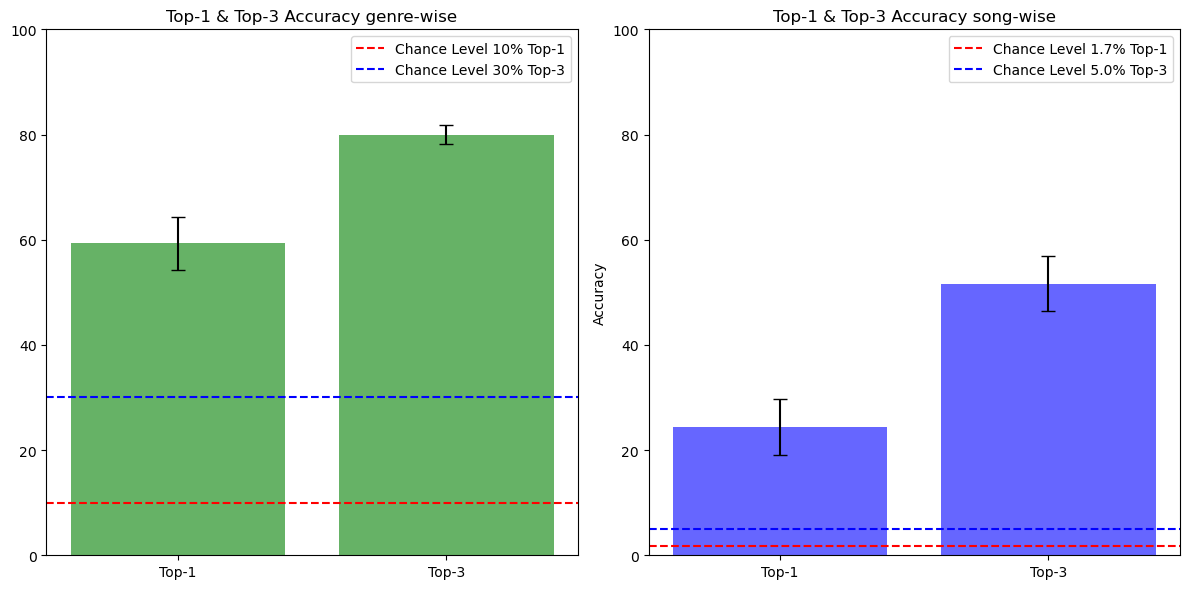

In [47]:
# Create a figure and axis
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
labels_top = ['Top-1', 'Top-3']

# Right figure (chance level 1/60)
axs[1].bar(labels_top, [top_1_song_mean, top_3_song_mean], yerr=[top_1_song_std, top_3_song_std], capsize=5, color='b', alpha=0.6)
axs[1].axhline(y=1.67, color='r', linestyle='--', label='Chance Level 1.7% Top-1')
axs[1].axhline(y=5.0, color='b', linestyle='--', label='Chance Level 5.0% Top-3')
axs[1].set_ylim(0, 100)
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Top-1 & Top-3 Accuracy song-wise')
axs[1].legend()
axs[1].set_xticks(labels_top)
axs[1].grid(False) 

# Left figure (chance level 6/60)
axs[0].bar(labels_top, [top_1_genre_mean, top_3_genre_mean], yerr=[top_1_genre_std, top_3_genre_std], capsize=5, color='g', alpha=0.6)
axs[0].axhline(y=10, color='r', linestyle='--', label='Chance Level 10% Top-1')
axs[0].axhline(y=30, color='b', linestyle='--', label='Chance Level 30% Top-3')
axs[0].set_ylim(0, 100)
axs[0].set_title('Top-1 & Top-3 Accuracy genre-wise')
axs[0].legend()
axs[0].set_xticks(labels_top)
axs[0].grid(False) 

plt.tight_layout()
plt.show()

In [169]:
song_id = 22
print(test_stim_name_avg_aligned[:60][song_id])

/data01/data/fMRI_music_genre/data_wav/genres_original/disco/disco.00072.wav


In [170]:
test_stim_name_avg_aligned[:60][top_indices_3[song_id]], top_indices_3[song_id]

(array(['/data01/data/fMRI_music_genre/data_wav/genres_original/disco/disco.00072.wav',
        '/data01/data/fMRI_music_genre/data_wav/genres_original/disco/disco.00004.wav',
        '/data01/data/fMRI_music_genre/data_wav/genres_original/disco/disco.00011.wav'],
       dtype=object),
 array([22, 19, 20]))

In [174]:
import librosa
from scipy.io.wavfile import write
from moviepy.editor import ImageClip, AudioFileClip

# base = 'original_'
base = 'retrieved_'
retrieved_id = 2
genre_id = 'disco'
# y, sr = librosa.load(test_stim_name_avg_aligned[:60][song_id], sr=22050)
y, sr = librosa.load(test_stim_name_avg_aligned[:60][top_indices_3[song_id]][retrieved_id], sr=22050)

piece = test_stim_name_avg_aligned[:60][top_indices_3[song_id]][retrieved_id][-9:]     # to change
# piece = 'disco.00072'
end_sample = 22050 * 15  
y_cut = y[:end_sample]
output_path = '/home/matteoc/genre-to-fmri/spectr_retrieve/'+genre_id
write(output_path+'/'+genre_id+'_'+base+piece+'.wav', 22050, (y_cut * 32767).astype('int16'))

S = librosa.stft(y_cut)
S_db = librosa.amplitude_to_db(abs(S), ref=np.max)
plt.figure(figsize=(10, 5))
librosa.display.specshow(S_db, sr=22050, x_axis='time', y_axis='hz', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.tight_layout()

plt.savefig(output_path+'/'+genre_id+'_'+base+piece+'.png')
plt.close()

image_clip = ImageClip(output_path+'/'+genre_id+'_'+base+piece+'.png').set_duration(15)  # Duration should match the audio length
audio_clip = AudioFileClip(output_path+'/'+genre_id+'_'+base+piece+'.wav').set_duration(15)

video = image_clip.set_audio(audio_clip)
video.write_videofile(output_path+'/'+genre_id+'_'+base+piece+'.mp4', fps=24)




Moviepy - Building video /home/matteoc/genre-to-fmri/spectr_retrieve/disco/disco_retrieved_00011.wav.mp4.
MoviePy - Writing audio in disco_retrieved_00011.wavTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/matteoc/genre-to-fmri/spectr_retrieve/disco/disco_retrieved_00011.wav.mp4



Moviepy - Done !
Moviepy - video ready /home/matteoc/genre-to-fmri/spectr_retrieve/disco/disco_retrieved_00011.wav.mp4


In [34]:
working_data_dict_avg[f"sub-00{sub_idx}"]["test_stim_name_avg"][top_indices[idx]]

array(['/data01/data/fMRI_music_genre/data_wav/genres_original/jazz/jazz.00014.wav',
       '/data01/data/fMRI_music_genre/data_wav/genres_original/jazz/jazz.00044.wav',
       '/data01/data/fMRI_music_genre/data_wav/genres_original/jazz/jazz.00045.wav',
       '/data01/data/fMRI_music_genre/data_wav/genres_original/jazz/jazz.00069.wav',
       '/data01/data/fMRI_music_genre/data_wav/genres_original/classical/classical.00092.wav'],
      dtype=object)

## Figures

### Feature representations

In [33]:
audio_feat_example=train_audio_feat_aligned[:480]
audio_genre_example=train_genre_aligned[:480]

In [36]:
# train_genre_aligned

In [34]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Run t-SNE to reduce dimensionality
tsne = TSNE(n_components=2, random_state=0)
audio_feat_reduced = tsne.fit_transform(audio_feat_example)


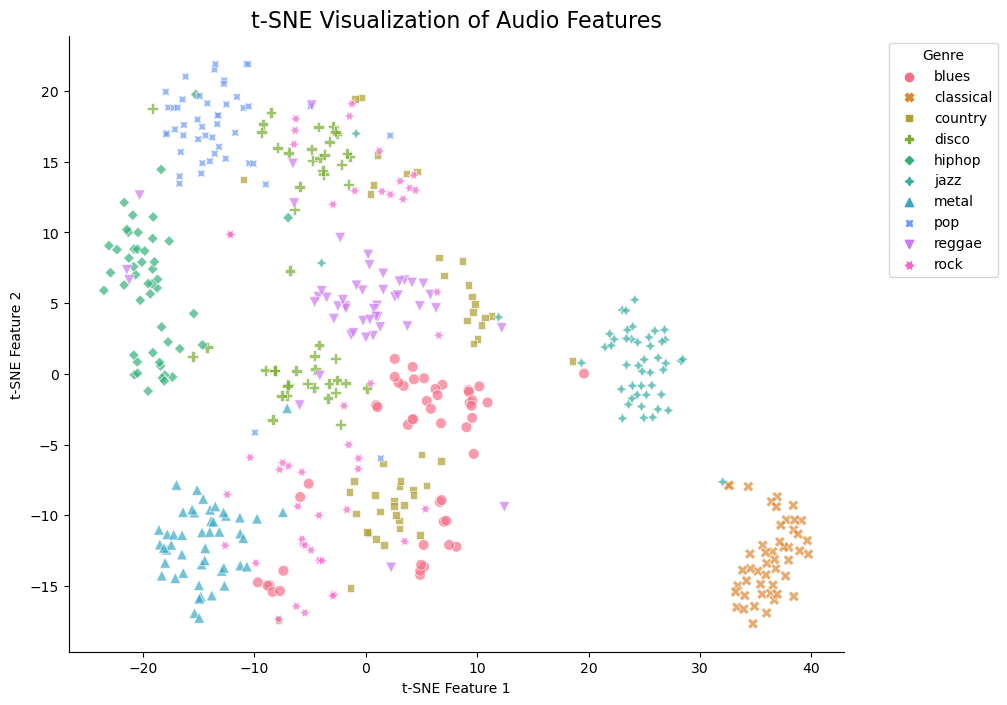

In [35]:
# Step 2: Plotting
plt.figure(figsize=(10, 8))

# Create a custom color palette
palette = sns.color_palette("husl", len(np.unique(audio_genre_example)))


# Create a scatter plot
sns.scatterplot(x=audio_feat_reduced[:, 0], y=audio_feat_reduced[:, 1], hue=audio_genre_example,
                palette=palette,style=audio_genre_example, s=60, edgecolor='w', alpha=0.7)

# Enhance aesthetics
plt.title('t-SNE Visualization of Audio Features', fontsize=16)
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
sns.despine()  # Remove top and right borders

# Add a legend outside the plot
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc=2)

plt.show()


## Plot the mask

In [22]:
from nilearn import plotting

In [23]:
nib_mask=nib.load(mask_path)

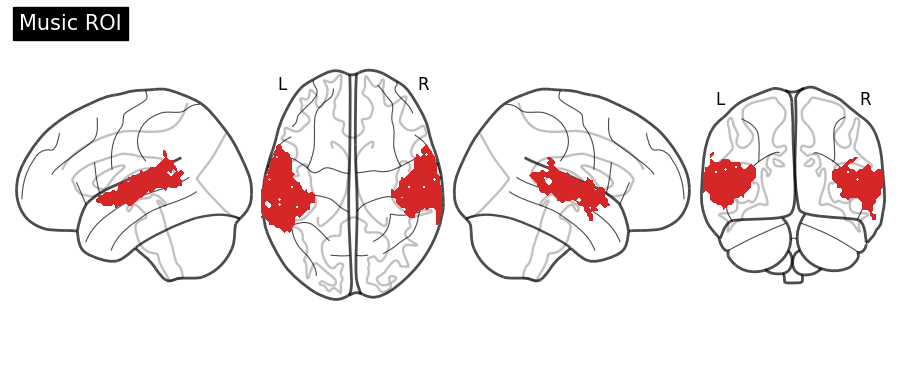

In [24]:
display=plotting.plot_glass_brain(None, display_mode="lzry", title="Music ROI")
display.add_contours(nib_mask, filled=True, colors="tab:red")

display.savefig('figures/brain_roi.png',dpi=300)

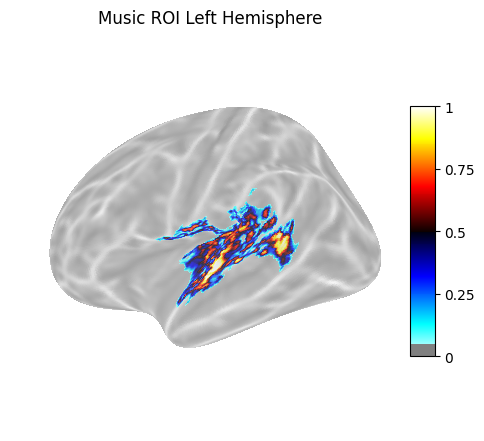

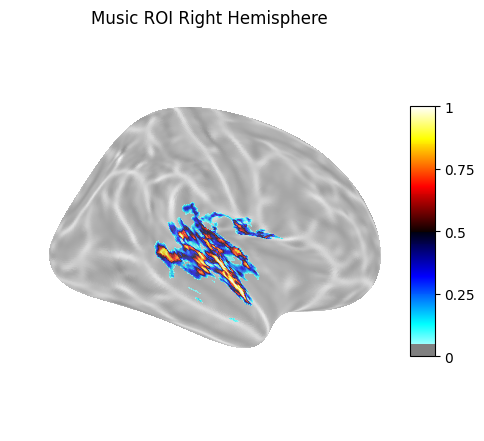

In [50]:
from nilearn import surface
from nilearn.datasets import fetch_surf_fsaverage

# Get the fsaverage5 mesh
fsaverage = fetch_surf_fsaverage("fsaverage")
texture_left = surface.vol_to_surf(nib_mask, fsaverage.pial_left)
texture_right = surface.vol_to_surf(nib_mask, fsaverage.pial_right)

# Plot the surface map
plotting.plot_surf_stat_map(fsaverage.infl_left, texture_left,
                            hemi='left', view='lateral', colorbar=True,
                            title="Music ROI Left Hemisphere", threshold=0.05, bg_map=fsaverage.curv_left, bg_on_data=True,
                            darkness=0.5, cmap='cold_hot')

plotting.plot_surf_stat_map(fsaverage.infl_right, texture_right,
                            hemi='right', view='lateral', colorbar=True,
                            title="Music ROI Right Hemisphere", threshold=0.05, bg_map=fsaverage.curv_right, bg_on_data=True,
                            darkness=0.5, cmap='cold_hot')

plotting.show()

In [26]:
nib_mask.get_fdata().sum()

3043.0

## Ceiling performances

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

clf_ceiling = LogisticRegression(C=50,random_state=42).fit(train_audio_feat_aligned, train_genre_aligned)

test_genre_pred_from_clap = clf_ceiling.predict(test_audio_feat_aligned)

print(classification_report(test_genre_aligned,test_genre_pred_from_clap))


              precision    recall  f1-score   support

       blues       0.83      1.00      0.91        30
   classical       1.00      0.90      0.95        30
     country       0.96      0.77      0.85        30
       disco       1.00      0.67      0.80        30
      hiphop       1.00      0.83      0.91        30
        jazz       0.91      1.00      0.95        30
       metal       0.74      0.97      0.84        30
         pop       1.00      1.00      1.00        30
      reggae       0.93      0.83      0.88        30
        rock       0.67      0.87      0.75        30

    accuracy                           0.88       300
   macro avg       0.90      0.88      0.88       300
weighted avg       0.90      0.88      0.88       300



## Direct classification from the brain

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

clf_direct_brain = LogisticRegression(C=50,random_state=42).fit(X_train_aligned, train_genre_aligned)

test_genre_pred_from_brain = clf_direct_brain.predict(X_test_aligned)

print(classification_report(test_genre_aligned,test_genre_pred_from_brain))


              precision    recall  f1-score   support

       blues       0.48      0.47      0.47        30
   classical       0.73      1.00      0.85        30
     country       0.43      0.53      0.48        30
       disco       0.33      0.33      0.33        30
      hiphop       0.64      0.83      0.72        30
        jazz       0.74      0.57      0.64        30
       metal       0.55      0.60      0.57        30
         pop       0.61      0.67      0.63        30
      reggae       0.61      0.47      0.53        30
        rock       0.25      0.10      0.14        30

    accuracy                           0.56       300
   macro avg       0.54      0.56      0.54       300
weighted avg       0.54      0.56      0.54       300



## Genre classification from estiamted clap features from the brain

Try to use the same model of the ceiling but with estiamted features

In [52]:
train_audio_feat_aligned.mean(), train_audio_feat_aligned.std(), audio_feat_pred.mean(), audio_feat_pred.std()

(-0.0005942661985135746,
 0.044180970626801666,
 -0.0005942661985135745,
 0.04902074463935425)

In [53]:
test_genre_pred_from_estimated_brain = clf_ceiling.predict(audio_feat_pred)

print(classification_report(test_genre_aligned,test_genre_pred_from_estimated_brain))

              precision    recall  f1-score   support

       blues       0.43      0.40      0.41        30
   classical       0.70      0.77      0.73        30
     country       0.36      0.40      0.38        30
       disco       0.44      0.50      0.47        30
      hiphop       0.88      0.70      0.78        30
        jazz       0.70      0.63      0.67        30
       metal       0.52      0.47      0.49        30
         pop       0.65      0.73      0.69        30
      reggae       0.59      0.67      0.62        30
        rock       0.27      0.23      0.25        30

    accuracy                           0.55       300
   macro avg       0.55      0.55      0.55       300
weighted avg       0.55      0.55      0.55       300



## Nearest Neighbors

In [54]:
def extract_genre(path):
    # Extracts the genre part from the given file path.
    parts = path.split('/')
    for i, part in enumerate(parts):
        if part == 'genres_original' and i + 1 < len(parts):
            return parts[i + 1]
    return None

In [55]:
top_indices


array([[30, 33, 32,  7, 11],
       [51, 31, 24,  5,  1],
       [23, 36, 40, 41,  2],
       ...,
       [56, 57, 19, 17, 58],
       [58, 44, 15,  3, 21],
       [22, 59, 19, 23,  2]])

In [56]:
def calculate_retr_accuracy(test_paths,top_indices, top_k=1):
    test_genres = np.array([extract_genre(path) for path in test_paths])

    print(test_genres.shape, top_indices.shape)
    correct_count = 0
    for i, test_genre in enumerate(test_genres):
        # Get the top-k predictions from the neighbors
        predicted_genres = [test_genres[idx] for idx in top_indices[i][:top_k]]
        # Check if the actual genre is in the top-k predicted genres
        if test_genre in predicted_genres:
            correct_count += 1

    accuracy = correct_count / len(test_genres)
    return accuracy

# Using the function to compute Top-1 and Top-3 accuracy
top1_accuracy = calculate_retr_accuracy(test_stim_name_avg_aligned, top_indices, top_k=1)
top3_accuracy = calculate_retr_accuracy(test_stim_name_avg_aligned, top_indices, top_k=3)

print("Top-1 Accuracy:", top1_accuracy)
print("Top-3 Accuracy:", top3_accuracy)

(300,) (300, 5)
(300,) (300, 5)
Top-1 Accuracy: 0.5933333333333334
Top-3 Accuracy: 0.8


In [57]:
knn_genre_predictions = test_genre_aligned[top_indices[:,0]]

In [58]:
print(classification_report(test_genre_aligned,knn_genre_predictions))

              precision    recall  f1-score   support

       blues       0.50      0.37      0.42        30
   classical       0.90      0.87      0.88        30
     country       0.70      0.53      0.60        30
       disco       0.32      0.37      0.34        30
      hiphop       0.65      0.67      0.66        30
        jazz       0.68      0.90      0.77        30
       metal       0.65      0.50      0.57        30
         pop       0.73      0.80      0.76        30
      reggae       0.50      0.60      0.55        30
        rock       0.34      0.33      0.34        30

    accuracy                           0.59       300
   macro avg       0.60      0.59      0.59       300
weighted avg       0.60      0.59      0.59       300



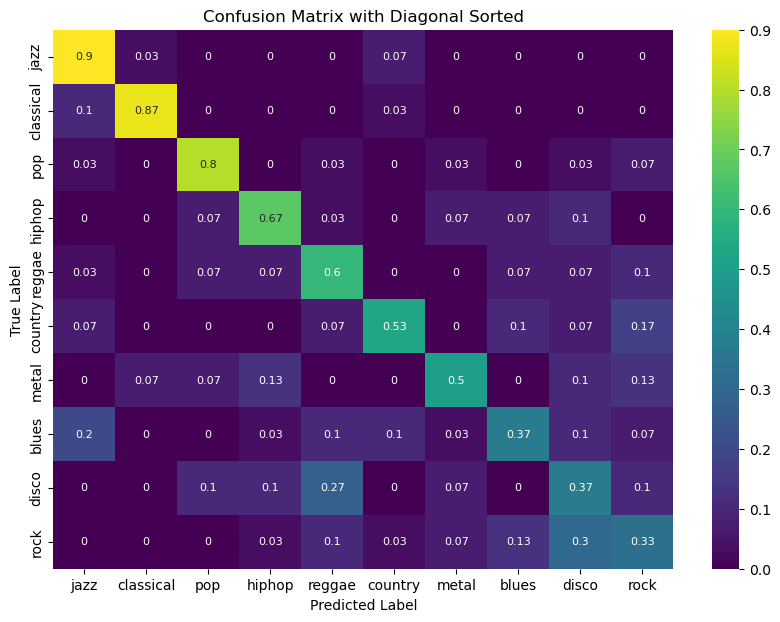

In [59]:
# Compute the confusion matrix
cm = confusion_matrix(test_genre_aligned, knn_genre_predictions)

# Extract the unique labels
labels = np.unique(test_genre_aligned)

# Sort labels based on the diagonal values of the confusion matrix in descending order
sorted_indices = np.argsort(-np.diag(cm))
sorted_labels = labels[sorted_indices]

# Reorder the confusion matrix
sorted_cm = cm[:, sorted_indices][sorted_indices]/30
sorted_cm = np.round(sorted_cm, 2)

# Plot the sorted confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(sorted_cm, annot=True, cmap="viridis", fmt="g", xticklabels=sorted_labels, yticklabels=sorted_labels, 
            annot_kws={"size": 8})
plt.title('Confusion Matrix with Diagonal Sorted')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Plot Identification Accuracy in time

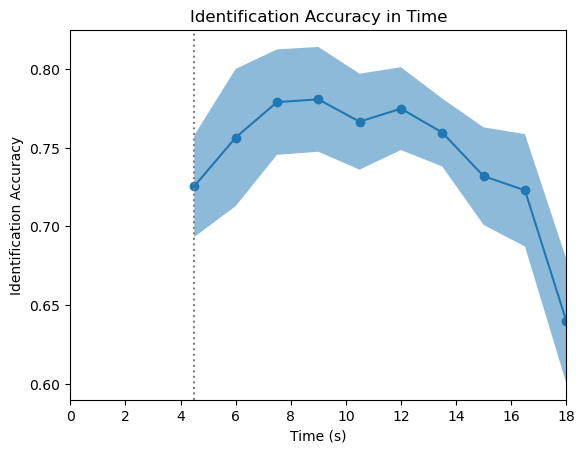

In [53]:
mean_vect = np.array([0.7256, 0.7565, 0.7790, 0.7808, 0.7666, 0.7749, 0.7597, 0.7320, 0.7230, 0.6400])
std_vect = np.array([0.0323, 0.0436, 0.0335, 0.0333, 0.0305, 0.0263, 0.0216, 0.0310, 0.0357, 0.0394])
n_timepoints = np.arange(fmri_vol_delay, fmri_vol_delay+how_many_fmri_vols) * TR

fig, ax = plt.subplots()
ax.plot(n_timepoints, mean_vect)
ax.scatter(n_timepoints, mean_vect, c='tab:blue')
ax.fill_between(n_timepoints, mean_vect + std_vect, mean_vect - std_vect, alpha=0.5)

ax.set_xlim(0, max(n_timepoints))
ax.axvline(x=fmri_vol_delay*TR, color='grey', linestyle=':', linewidth=1.5)

plt.title("Identification Accuracy in Time")
plt.xlabel("Time (s)")
plt.ylabel("Identification Accuracy")
plt.savefig('/home/matteoc/genre-to-fmri/figures/idacc_intime.pdf', format='pdf')
plt.savefig('/home/matteoc/genre-to-fmri/figures/idacc_intime.png', format='png', dpi=300)
plt.show()